In [27]:
%matplotlib inline

import numpy as np
import time

import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torch
import torch.nn as nn
import torch.nn.functional as F

from gensim.models import KeyedVectors 
import gensim.downloader as genapi
import gzip
import pickle
import random

import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [43]:
import torch
from torch import nn
# The following networks' designs were influenced
# by Professor Avinash Kak's DLStudio implementation.


class HW8():

    def __init__(self, root_path, train_path, val_path, word2vec_path):

        self.root_path = root_path
        self.train_path = self.root_path + train_path
        self.val_path = self.root_path + val_path
        self.path_word2vec = self.root_path + word2vec_path
        self.batch_size = 1
        self.lr = 0.0002
        self.device = torch.device(
            "cuda:0" if torch.cuda.is_available() else "cpu")
        self.debug = True

        if self.device.type == "cpu":
            self.num_workers = 0
        else:
            self.num_workers = 0

    class MyDataset(Dataset):
        def __init__(self, path_dataset, path_word2vec=None):
            super(HW8.MyDataset).__init__()

            f = gzip.open(path_dataset, 'rb')
            dataset = f.read()
            self.positive_reviews, self.negative_reviews, self.vocab = pickle.loads(
                dataset, encoding='latin1')
            self.reviews = []
            self.labels = []

            for category in self.positive_reviews:
                for review in self.positive_reviews[category]:
                    self.reviews.append(review)
                    self.labels.append(1)
            for category in self.negative_reviews:
                for review in self.negative_reviews[category]:
                    self.reviews.append(review)
                    self.labels.append(0)

            zipped = list(zip(self.reviews, self.labels))
            random.shuffle(zipped)

            self.reviews, self.labels = zip(*zipped)

            if path_word2vec is None:
                # Load the pre-trained word2vec model from Gensim
                self.word2vec = genapi.load('word2vec-google-news-300')
            else:
                self.word2vec = KeyedVectors.load(path_word2vec)

        def __len__(self):
            return len(self.reviews)

        def __getitem__(self, idx):
            review = self.reviews[idx]
            label = self.labels[idx]

            # Convert text to embeddings using word2vec
            review_embeddings = []
            for word in review:
                if word in self.word2vec:
                    word_embedding = self.word2vec[word]
                    review_embeddings.append(word_embedding)

            # Convert to tensors
            review_tensor = torch.tensor(
                np.array(review_embeddings), dtype=torch.float32)
            sentiment_tensor = torch.tensor(np.array(label), dtype=torch.long)

            return review_tensor, sentiment_tensor

    def load_train_data(self):
        dataset = self.MyDataset(self.train_path, self.path_word2vec)
        self.train_dataloader = DataLoader(
            dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def load_test_data(self):
        dataset = self.MyDataset(self.val_path, self.path_word2vec)
        self.test_dataloader = DataLoader(
            dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    class CustomGRU(nn.Module):
        def __init__(self, input_size, hidden_size):
            super(HW8.CustomGRU, self).__init__()

            self.input_size = input_size
            self.hidden_size = hidden_size
            ## for reset, update and candidate hidden state gates:
            self.W_z = nn.Linear(input_size + hidden_size, hidden_size)
            self.W_r = nn.Linear(input_size + hidden_size, hidden_size)
            self.W_h_hat = nn.Linear(input_size + hidden_size, hidden_size)

        def forward(self, input, hidden):
            
            combined = torch.cat((input, hidden), dim=1)
            r = torch.sigmoid(self.W_r(combined))
            z = torch.sigmoid(self.W_z(combined))
            h_hat = torch.tanh(self.W_h_hat(torch.cat((input, r * hidden), dim=1)))

            h = (1 - z) * h_hat + z * hidden

            return h

    class GRUNetCustom(nn.Module):
        def __init__(self, embedding_size, hidden_size, output_size, n_layers):
            super(HW8.GRUNetCustom, self).__init__()

            self.grus = nn.ModuleList(
                [HW8.CustomGRU(embedding_size, hidden_size) for _ in range(n_layers)])
            self.fc = nn.Linear(hidden_size, output_size)
            self.relu = nn.LeakyReLU(0.2, inplace=True)
            self.logsoftmax = nn.LogSoftmax(dim=1)

        def forward(self, text):

            batch_size, seq_len, _ = text.size()

            h = torch.rand(
                batch_size, self.grus[0].hidden_size, device=text.device, dtype=torch.float32)

            ## Loop through the entire sequence inside the network
            for w in range(seq_len):
                for gru_cell in self.grus:
                    h = gru_cell(text[:, w, :], h)

            linear_out = self.fc(self.relu(h))
            output = self.logsoftmax(linear_out)

            return output

    class GRUNet(nn.Module):
        def __init__(self, embedding_size, hidden_size, output_size, n_layers, dropout=0.1):
            super(HW8.GRUNet, self).__init__()
            ## nn.GRU() is used with 2 layers as for the custom GRU
            ## dropout is also added for regularization
            self.grus = nn.GRU(embedding_size, hidden_size,
                               num_layers=n_layers, batch_first=True, dropout=dropout)
            self.fc = nn.Linear(hidden_size, output_size)
            self.relu = nn.LeakyReLU(0.2, inplace=True)
            self.logsoftmax = nn.LogSoftmax(dim=1)

        def forward(self, text):

            ## Initial hidden state not provided, defaults to zeros
            gru_out, _ = self.grus(text)
            gru_out = gru_out[:, -1, :]
            linear_out = self.fc(self.relu(gru_out))
            output = self.logsoftmax(linear_out)

            return output

    class BidirectionalGRUnet(nn.Module):
        def __init__(self, embedding_size, hidden_size, output_size, n_layers, dropout=0.1):
            super(HW8.BidirectionalGRUnet, self).__init__()

            ## bidirectional parameter is turned on
            self.gru = nn.GRU(embedding_size, hidden_size, num_layers=n_layers,
                              batch_first=True, dropout=dropout, bidirectional=True)
            ## GRU's output is now a concat of the forward and backward pass
            ## of the sequence so the linear layer has double the hidden size
            self.fc = nn.Linear(2 * hidden_size, output_size)
            self.relu = nn.LeakyReLU(0.2, inplace=True)
            self.logsoftmax = nn.LogSoftmax(dim=1)

        def forward(self, text):

            ## Initial hidden state not provided, defaults to zeros
            gru_out, _ = self.gru(text)
            # Use the last hidden state from both directions
            h = gru_out[:, -1, :]
            linear_out = self.fc(self.relu(h))
            output = self.logsoftmax(linear_out)

            return output

    def run_gru_network(self, net, epochs=1, display_train_loss=False, model_name='gru'):
        filename_for_out = "performance_numbers_" + \
            str(epochs) + model_name + ".txt"
        FILE = open(filename_for_out, 'w')
        net = net.to(self.device)
        # Note that the GRUNetCustom now produces the LogSoftmax output:
        criterion = nn.NLLLoss()
        accum_times = []
        optimizer = optim.Adam(
            net.parameters(), lr=self.lr, betas=(0.75, 0.999))
        training_loss_tally = []
        start_time = time.perf_counter()
        for epoch in range(epochs):
            print("")
            running_loss = 0.0
            for i, data in enumerate(self.train_dataloader):
                review_tensor, sentiment = data[0], data[1]
                review_tensor = review_tensor.to(self.device)
                sentiment = sentiment.to(self.device)

                optimizer.zero_grad()
                # Forward pass
                output = net(review_tensor)

                loss = criterion(output, sentiment)
                running_loss += loss.item()
                loss.backward()
                optimizer.step()
                if i % 200 == 199:
                    avg_loss = running_loss / float(200)
                    training_loss_tally.append(avg_loss)
                    current_time = time.perf_counter()
                    time_elapsed = current_time-start_time
                    print("[epoch:%d  iter:%4d  elapsed_time:%4d secs]     loss: %.5f" % (
                        epoch+1, i+1, time_elapsed, avg_loss))
                    accum_times.append(current_time-start_time)
                    FILE.write("%.5f\n" % avg_loss)
                    FILE.flush()
                    running_loss = 0.0

        self.save_model(net, '{}G_{}.pt'.format(self.root_path, model_name))

        print("Total Training Time: {}".format(str(sum(accum_times))))
        print("\nFinished Training\n\n")
        if display_train_loss:
            plt.figure(figsize=(10, 5))
            plt.title("Training Loss vs. Iterations")
            plt.plot(training_loss_tally)
            plt.xlabel("iterations")
            plt.ylabel("training loss")
            plt.legend()
            plt.savefig("training_loss.png")
            plt.show()

        self.loss = training_loss_tally

        return training_loss_tally

    def evaluate_gru_network(self, net):

        self.load_test_data()
        net.eval()
        net.to(self.device)

        true_labels = []
        predicted_labels = []

        with torch.no_grad():
            for data in self.test_dataloader:
                review_tensor, sentiment = data
                review_tensor = review_tensor.to(self.device)
                sentiment = sentiment.to(self.device)

                outputs = net(review_tensor)
                _, predicted = torch.max(outputs, 1)

                true_labels.extend(sentiment.tolist())
                predicted_labels.extend(predicted.tolist())

        cm = confusion_matrix(true_labels, predicted_labels)
        sns.heatmap(cm, annot=True, fmt='d')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

        accuracy = (cm[0][0] + cm[1][1]) / cm.sum()
        print("Accuracy: {:.2f}%".format(accuracy * 100))

    def save_model(self, model, PATH):
        '''
        Save the trained model to a disk file
        '''
        torch.save(model, PATH)

    def load_model(self, PATH):
        '''
        Load the trained model to a disk file
        '''
        model = torch.load(PATH, map_location=self.device)
        return model


In [44]:
root_path = ''
train_path = 'data/sentiment_dataset_train_400.tar.gz'
test_path = 'data/sentiment_dataset_test_400.tar.gz'
word2vec_path = 'data/word2vec/vectors.kv'


# Sentiment Analysis with Your Own GRU

## Train your GRU-based RNN

In [ ]:
hw8_custom_GRU = HW8(root_path, train_path, test_path, word2vec_path)
hw8_custom_GRU.load_train_data()
hw8_custom_GRU_net = hw8_custom_GRU.GRUNetCustom(
    embedding_size=300, hidden_size=100, output_size=2, n_layers=2)
custom_GRU_losses = hw8_custom_GRU.run_gru_network(
    hw8_custom_GRU_net, epochs=5, display_train_loss=True, model_name='custom_gru')


The vanishing gradient problem happens when gradients get too small during backpropagation. This makes it hard for the network to learn long-term relationships. This problem makes it harder for RNNs to get information from earlier steps in the sequence.

The vanishing gradient problem is mitigated by the use of gating methods in the GRU. Let's take apart the way CustomGRU cells are set up and explain why:

1. Initialization: 
- The CustomGRU cell takes two parameters, input_size and hidden_size, and sets up three Linear layers (W_r, W_z, and W_h_hat), which are in charge of the update gate (z), reset gate (r), and candidate hidden state (h_hat).
2. Forward pass:
- A single tensor is produced by joining the hidden and input states.
- The update (z) and reset (r) gates are calculated by running the combined tensor through the relevant Linear layers and a sigmoid activation function. The sigmoid function squeezes the values between 0 and 1, making it easier for the gates to control how information flows.
- The candidate hidden state (h_hat) is calculated by feeding the concatenated tensor (input and element-wise multiplication of the reset gate (r) with the hidden state) through the W_h_hat Linear layer, which is then followed by a tanh activation function. The tanh function takes numbers from -1 to 1 and makes them smaller.
- The update gate (z), the candidate hidden state (h_hat), and the previous hidden state are all used to figure out the new hidden state.

The GRU's gating methods mitigate the vanishing gradient problem by limiting the flow of input through the network. Using the update and reset gates, the GRU can decide what information to keep and what to throw away. This selective memory enables the GRU to learn relationships more effectively while reducing the effect of vanishing gradients.

## Custom GRU Losses

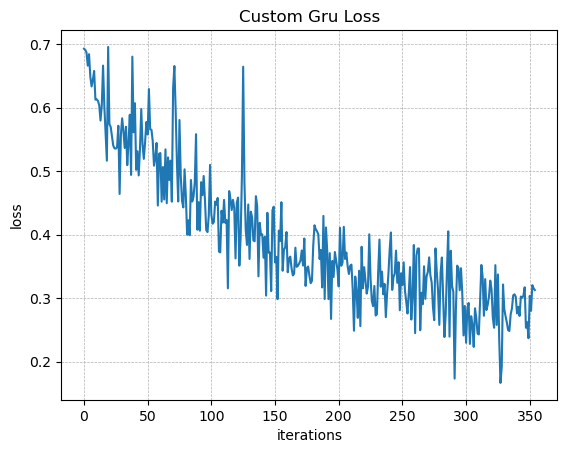

In [52]:
plt.plot(custom_GRU_losses)
plt.title("Custom Gru Loss")
plt.xlabel("iterations")
plt.ylabel("loss")
plt.grid(linestyle = '--', linewidth = 0.5)
plt.show()

## Evaluating the CustomGRU

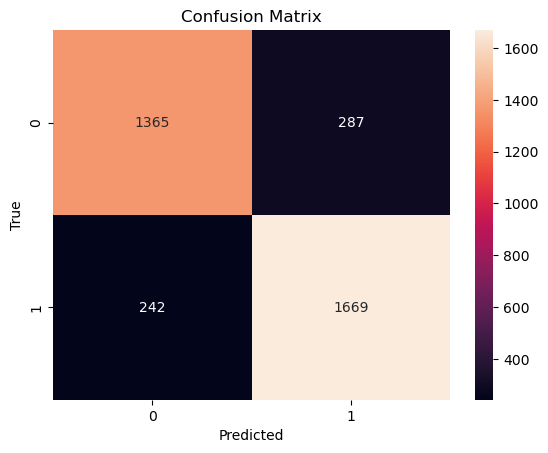

Accuracy: 85.15%


In [46]:
hw8_custom_GRU.evaluate_gru_network(hw8_custom_GRU_net)

The CustomGRU model's accuracy is 85.15%, indicating good performance. The precision and recall scores show that the model predicts class 1 instances slightly better than class 0 instances. 

# Sentiment Analysis with Pytorch GRU

## Train your GRU-based RNN

In [ ]:
hw8_pytorch_GRU = HW8(root_path, train_path, test_path, word2vec_path)
hw8_pytorch_GRU.load_train_data()
hw8_pytorch_GRU_net = hw8_pytorch_GRU.GRUNet(
    embedding_size=300, hidden_size=100, output_size=2, n_layers=2, dropout=0.1)
pytorch_GRU_losses = hw8_pytorch_GRU.run_gru_network(
    hw8_pytorch_GRU_net, epochs=5, display_train_loss=True, model_name='pytorch_gru')


## Pytorch GRU Losses

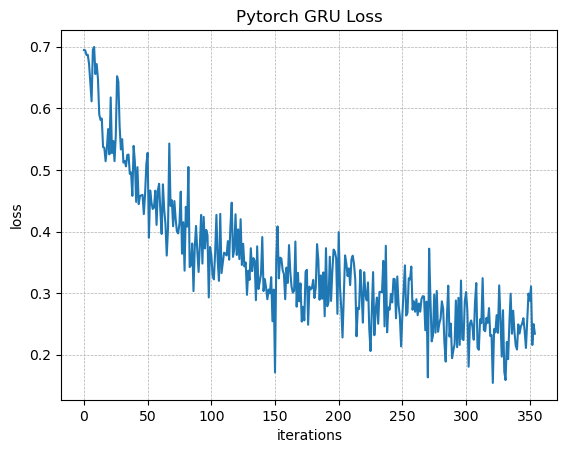

In [54]:
plt.plot(pytorch_GRU_losses)
plt.title("Pytorch GRU Loss")
plt.xlabel("iterations")
plt.ylabel("loss")
plt.grid(linestyle = '--', linewidth = 0.5)
plt.show()

## Evaluating the Pytorch GRU

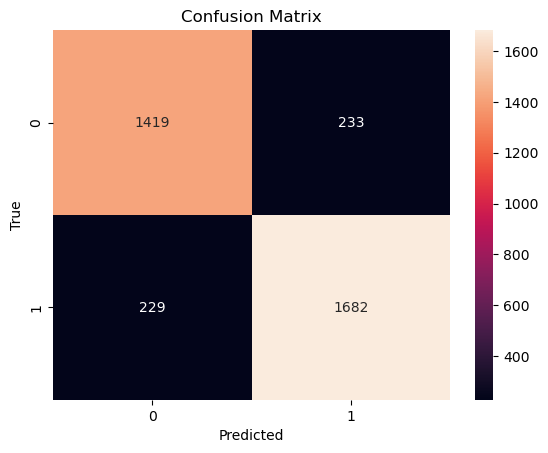

Accuracy: 87.03%


In [48]:
hw8_pytorch_GRU.evaluate_gru_network(hw8_pytorch_GRU_net)

The accuracy of the PytorchGRU model is 87.03%, which indicates that it outperforms the custom GRU implementation. Not only that, but the performance was **significantly faster**. The Pytorch GRU network implementation completed all five epochs nearly three times faster.  

# Sentiment Analysis with Pytorch Bidirectional GRU 

In [ ]:
hw8_bidirectional_GRU = HW8(root_path, train_path, test_path, word2vec_path)
hw8_bidirectional_GRU.load_train_data()
hw8_bidirectional_net = hw8_bidirectional_GRU.BidirectionalGRUnet(
    embedding_size=300, hidden_size=100, output_size=2, n_layers=2)
bidirectional_GRU_losses = hw8_bidirectional_GRU.run_gru_network(
    hw8_bidirectional_net, epochs=5, display_train_loss=True, model_name='bidirectional_gru')


## Bidirectional Pytorch GRU Losses

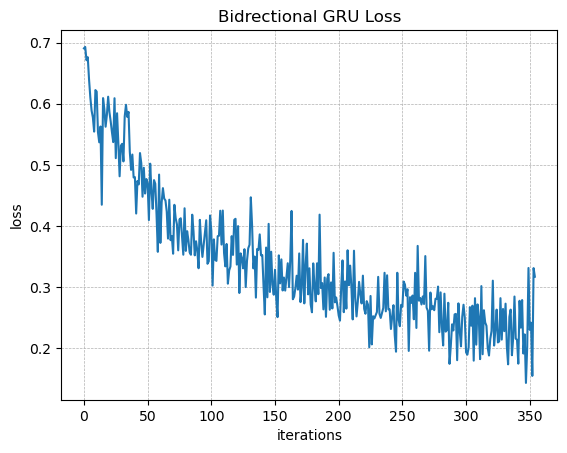

In [55]:
plt.plot(bidirectional_GRU_losses)
plt.title("Bidrectional GRU Loss")
plt.xlabel("iterations")
plt.ylabel("loss")
plt.grid(linestyle = '--', linewidth = 0.5)
plt.show()

## Evaluating the Bidirectional Pytorch GRU

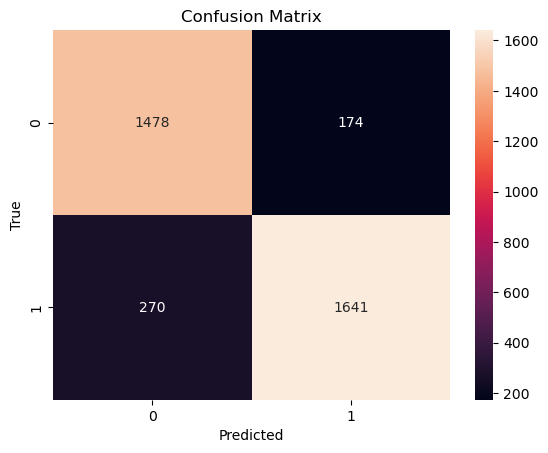

Accuracy: 87.54%


In [50]:
hw8_bidirectional_GRU = HW8('', train_path, test_path, word2vec_path)
hw8_bidirectional_GRU.evaluate_gru_network(hw8_bidirectional_net)


The accuracy of the Bidirectional PytorchGRU model is 87.54%, which indicates that it slightly outperforms the unidirectional Pytorch GRU implementation. Because it processes the input sequence in both forward and backward directions, a bidirectional GRU is superior to a unidirectional GRU. When making predictions, the model can now account for both past and future context. It was interesting that the training time was almost the double of the unidirectional PytorchGRU model, which might make sense because the flow of information is doubled. 